<a href="https://colab.research.google.com/github/Inbal-Schekler/UNET-flocks-detection/blob/main/evaluate_performance_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras import metrics
import tensorflow as tf
import glob
import random
import cv2
import math
from random import shuffle
from datetime import datetime
import re
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc


### **Dataset**


In [4]:

### list of test images

test_files_n = glob.glob('/content/train_test/Data_github/test/*/*/*/*/*.tiff')

test_files = sorted(test_files_n, key=lambda file: datetime.strptime(
    re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))

print("length of test files", len(test_files))

length of test files 1370


Functions from the github

In [8]:
! git clone https: // github.com/Inbal-Schekler/UNET-flocks-detection

Cloning into 'UNET-flocks-detection'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 102 (delta 14), reused 0 (delta 0), pack-reused 72
Receiving objects: 100% (102/102), 2.24 MiB | 27.62 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [9]:
os.chdir('/content/UNET-flocks-detection/functions')

In [11]:
from create_previous_images import create_early_image_2
from generators import image_generator
from unet_model import unet



In [12]:
model = unet()

Loading the weights of the best epoch

In [13]:
## To load the relevant epoch to the files of colab

model.load_weights('/content/my_best_model_2.epoch17-loss0.01.hdf5')

In [15]:
box = (29, 29, 450, 450)
num_past = 2
minuts = 7
batch_size = 32

test_generator = image_generator(test_files, num_past=num_past, minuts=minuts, box=box, batch_size=batch_size)

Creating array of the test files for predictions


In [16]:
batch_size = 32

test_steps = len(test_files) // batch_size

x_1 = batch_size * test_steps

x_test = np.zeros((x_1, 256, 256, 9))
y_test = np.zeros((x_1, 256, 256, 1))

right = 0
left = 0

for x_i, y_i in test_generator:

    left = right
    right += x_i.shape[0]
    if right >= x_1:
        break

    x_test[left:right, :, :, :] = x_i
    y_test[left:right, :, :, :] = y_i

x_test = x_test[:left, :, :, :]
y_test = y_test[:left, :, :, :]

print('x_test', x_test.shape)
print('y_test', y_test.shape)






x_test (1325, 256, 256, 9)
y_test (1325, 256, 256, 1)


In [17]:
predict = model.predict(x_test)
print(predict.shape)



(1325, 256, 256, 1)


In [18]:
y_pred_0_1 = np.copy(predict)
y_pred_0_1[y_pred_0_1 >= 0.5] = 1
y_pred_0_1[y_pred_0_1 < 0.5] = 0

##Show some examples of the predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


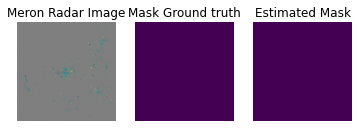

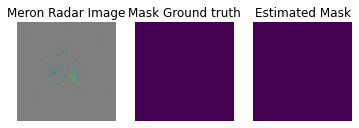

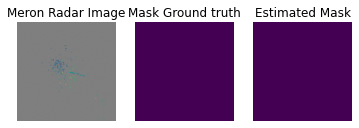

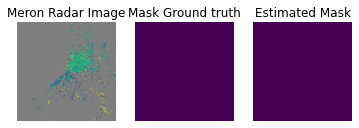

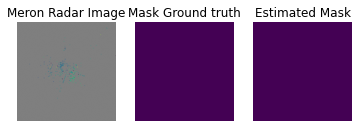

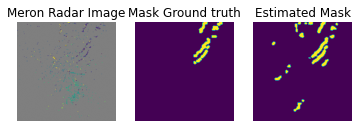

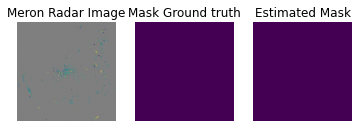

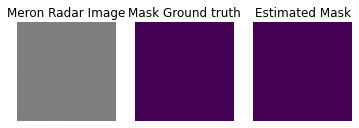

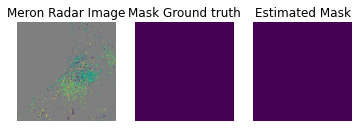

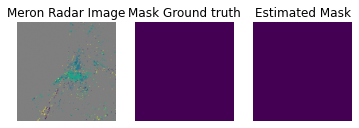

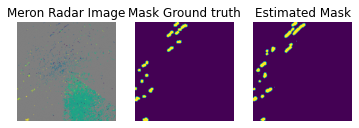

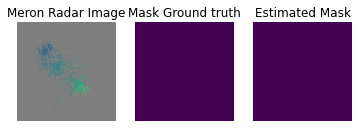

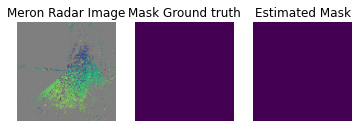

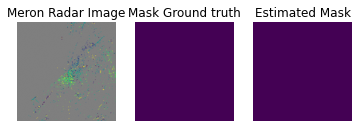

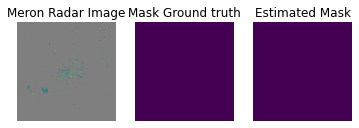

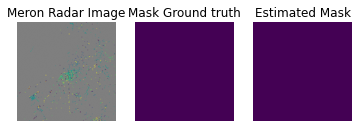

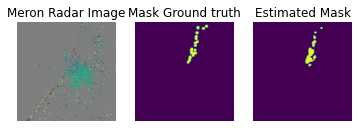

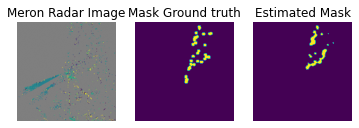

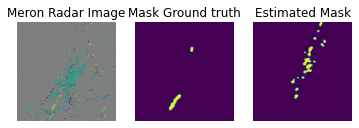

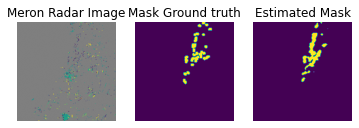

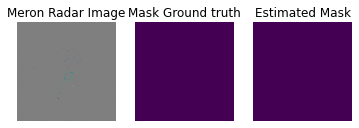

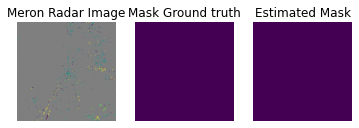

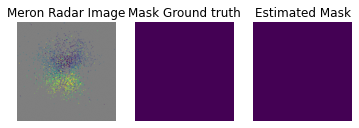

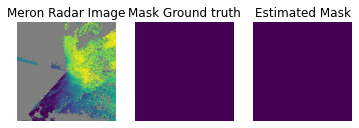

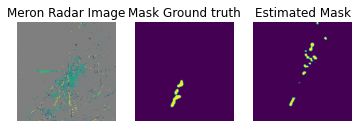

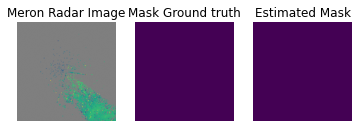

In [21]:
from IPython.core.pylabtools import figsize
import matplotlib.gridspec as gridspec

y_pred = np.copy(y_pred_0_1)

for i, img in enumerate(x_test):
    if i > 25:
        break

    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img[:, :, 0:3])
    axarr[0].axis('off')
    axarr[0].set_title('Meron Radar Image')
    axarr[1].imshow(y_test[i].squeeze())
    axarr[1].axis('off')
    axarr[1].set_title('Mask Ground truth')
    axarr[2].imshow(y_pred[i].squeeze())
    axarr[2].axis('off')
    axarr[2].set_title('Estimated Mask')

Evaluating the model on a contour level

In [22]:

def find_contours(y_test, y_pred):
    test = y_test
    pred = y_pred.squeeze()

    ## converting to unit8
    test = cv2.convertScaleAbs(test)
    pred = cv2.convertScaleAbs(pred)

    # converting it to color image so I can show on it the contours
    pred_col = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)
    test_col = cv2.cvtColor(test, cv2.COLOR_GRAY2RGB)
    pred_col[pred_col == 1] = 255
    test_col[test_col == 1] = 255

    # Find all contours in the greyscale image.
    contours_pred, hierarchy_pred = cv2.findContours(pred, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    contours_test, hierarchy_test = cv2.findContours(test, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    return (pred_col, contours_pred, test_col, contours_test)


def create_feature_df(img, contours_list):
    Center_x = []
    Center_y = []
    len_maj = []
    len_min = []
    Angle = []
    Area = []
    im_copy = img.copy()
    for i, cont in enumerate(contours_list):
        if len(cont) > 5:
            if cv2.contourArea(cont) > 15:
                (x, y), (MA, ma), angle = cv2.fitEllipse(cont)
                Center_x.append(x)
                Center_y.append(y)
                len_maj.append(MA)
                len_min.append(ma)
                Angle.append(angle)
                area = math.pi * MA * ma
                Area.append(area)

    list_of_columns = list(zip(Center_x, Center_y, len_maj, len_min, Angle, Area))
    contours_df = pd.DataFrame(list_of_columns, columns=['Center_x', 'Center_y', 'len_maj', 'len_min', 'Angle', 'Area'])

    return (contours_df)




In [23]:


def compare_test_pred_one_image(cont_df_test, cont_df_pred):
    fit_flocks = []
    cont_df_pred_index = []

    for index, row in cont_df_test.iterrows():

        low_x = row['Center_x'] - 30
        high_x = row['Center_x'] + 30
        low_y = row['Center_y'] - 30
        high_y = row['Center_y'] + 30

        if cont_df_pred['Center_x'].between(low_x, high_x).any():
            if cont_df_pred['Center_y'].between(low_y, high_y).any():

                low_size = row['Area'] * 0.3
                high_size = row['Area'] * 3
                if cont_df_pred['Area'].between(low_size, high_size).any():
                    fit_flocks.append(index)

    fit_flocks_pred = []
    for index, row in cont_df_pred.iterrows():
        low_x = row['Center_x'] - 30
        high_x = row['Center_x'] + 30
        low_y = row['Center_y'] - 30
        high_y = row['Center_y'] + 30
        if cont_df_test['Center_x'].between(low_x, high_x).any():
            if cont_df_test['Center_y'].between(low_y, high_y).any():
                low_size = row['Area'] * 0.3
                high_size = row['Area'] * 3
                if cont_df_test['Area'].between(low_size, high_size).any():
                    fit_flocks_pred.append(index)

    tp = len(fit_flocks)
    fn = cont_df_test.shape[0] - len(fit_flocks)
    fp = cont_df_pred.shape[0] - len(fit_flocks_pred)
    num_cont_test = cont_df_test.shape[0]
    num_cont_pred = cont_df_pred.shape[0]

    return tp, fn, fp, num_cont_test, num_cont_pred





In [24]:

def pipeline(test_np, pred_np):
    TP = []
    FN = []
    FP = []
    NUM_cont_test = []
    NUM_cont_pred = []
    for i, image_test in enumerate(test_np):
        test = test_np[i]
        pred = pred_np[i]
        pred_img, pred_conts, test_img, test_conts = find_contours(test, pred)
        test_cont_df = create_feature_df(test_img, test_conts)
        pred_cont_df = create_feature_df(pred_img, pred_conts)
        Tp, Fn, Fp, Num_cont_test, Num_cont_pred = compare_test_pred_one_image(test_cont_df, pred_cont_df)
        TP.append(Tp)
        FN.append(Fn)
        FP.append(Fp)
        NUM_cont_test.append(Num_cont_test)
        NUM_cont_pred.append(Num_cont_pred)

    list_of_columns = list(zip(TP, FN, FP, NUM_cont_test, NUM_cont_pred))
    results = pd.DataFrame(list_of_columns, columns=['TP', 'FN', 'FP', 'Num_cont_test', 'Num_cont_pred'])

    return results




In [25]:

results_df = pipeline(y_test, y_pred)

results_df

,TP,FN,FP,Num_cont_test,Num_cont_pred
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
1320,12,0,0,12,11
1321,0,0,0,0,0
1322,9,0,1,9,11
1323,12,0,1,12,21


TPR (True Positive Rate)

In [26]:

tp_all = results_df["TP"].sum()
cont_test_all = results_df["Num_cont_test"].sum()

tp_success = tp_all / cont_test_all

print('TPR', tp_success)


TPR 0.9243452958292919


FPDR (False Positive Detection Rate)

In [27]:

fp_all = results_df["FP"].sum()
fp_positive = results_df.loc[results_df['FP'] > 0, 'FP'].sum()
cont_pred_all = results_df["Num_cont_pred"].sum()

fp_percent = fp_positive / cont_pred_all

print('FPDR', fp_percent)






FPDR 0.20508326029798424


Evaluating the model pixel level


Area under the ROC curve: 0.8403261430375112


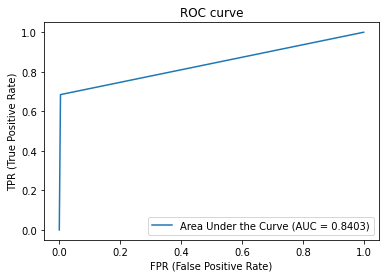

In [29]:


y_test = y_test.squeeze()
predict = predict.squeeze()
predictions = np.where(predict > 0.5, 1, 0)

y_scores = predictions.reshape(predictions.shape[0] * predictions.shape[1] * predictions.shape[2], 1)
#print(y_scores.shape)

y_true = y_test.reshape(y_test.shape[0] * y_test.shape[1] * y_test.shape[2], 1)
#print(y_true.shape)


y_scores = np.where(y_scores > 0.5, 1, 0)
y_true = np.where(y_true > 0.5, 1, 0)

fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
print("\nArea under the ROC curve: " + str(AUC_ROC))

roc_curve = plt.figure()
plt.plot(fpr, tpr, '-', label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")


In [ ]:
y_true = y_test.reshape(y_test.shape[0] * y_test.shape[1] * y_test.shape[2], 1)
#print(y_true.shape)


y_scores = np.where(y_scores > 0.5, 1, 0)
y_true = np.where(y_true > 0.5, 1, 0)

In [32]:

threshold_confusion = 0.5
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i] >= threshold_confusion:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print("\nF1 score (F-measure): " + str(F1_score))



F1 score (F-measure): 0.6149110309780796
